In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.image as mpimg
from scipy.ndimage import rotate
from itertools import product
from tqdm import tqdm
from utils import *
from sklearn.preprocessing import minmax_scale

animation.writer = animation.writers['ffmpeg']
plt.rcParams['figure.dpi'] = 900
plt.rcParams["figure.figsize"] = (9, 6)

### Data (solution arrays)

In [2]:
# # Unit is in m/s
# G_moon = 200 # m/s
# altitude = 500. # m
# x_pos = 0. # m? (don't think this really matters)
# entrance_x_vel = 300. # m/s
# pos = (x_pos, altitude)

# Unit is in m/s
# G_moon = 200 # m/s
altitude = 50. # m
x_pos = 5. # m? (don't think this really matters)
entrance_x_vel = 10. # m/s
pos = (x_pos, altitude)
gamma=0

In [3]:
TS, X, Y, XP, YP, UX, UY, TF = lunar_lander(pos, entrance_x_vel, gamma=0, beta=100, nu=5000, t_steps=10000)
print(np.min(Y))

-0.0006968954739209957


### Basic Info Plots 

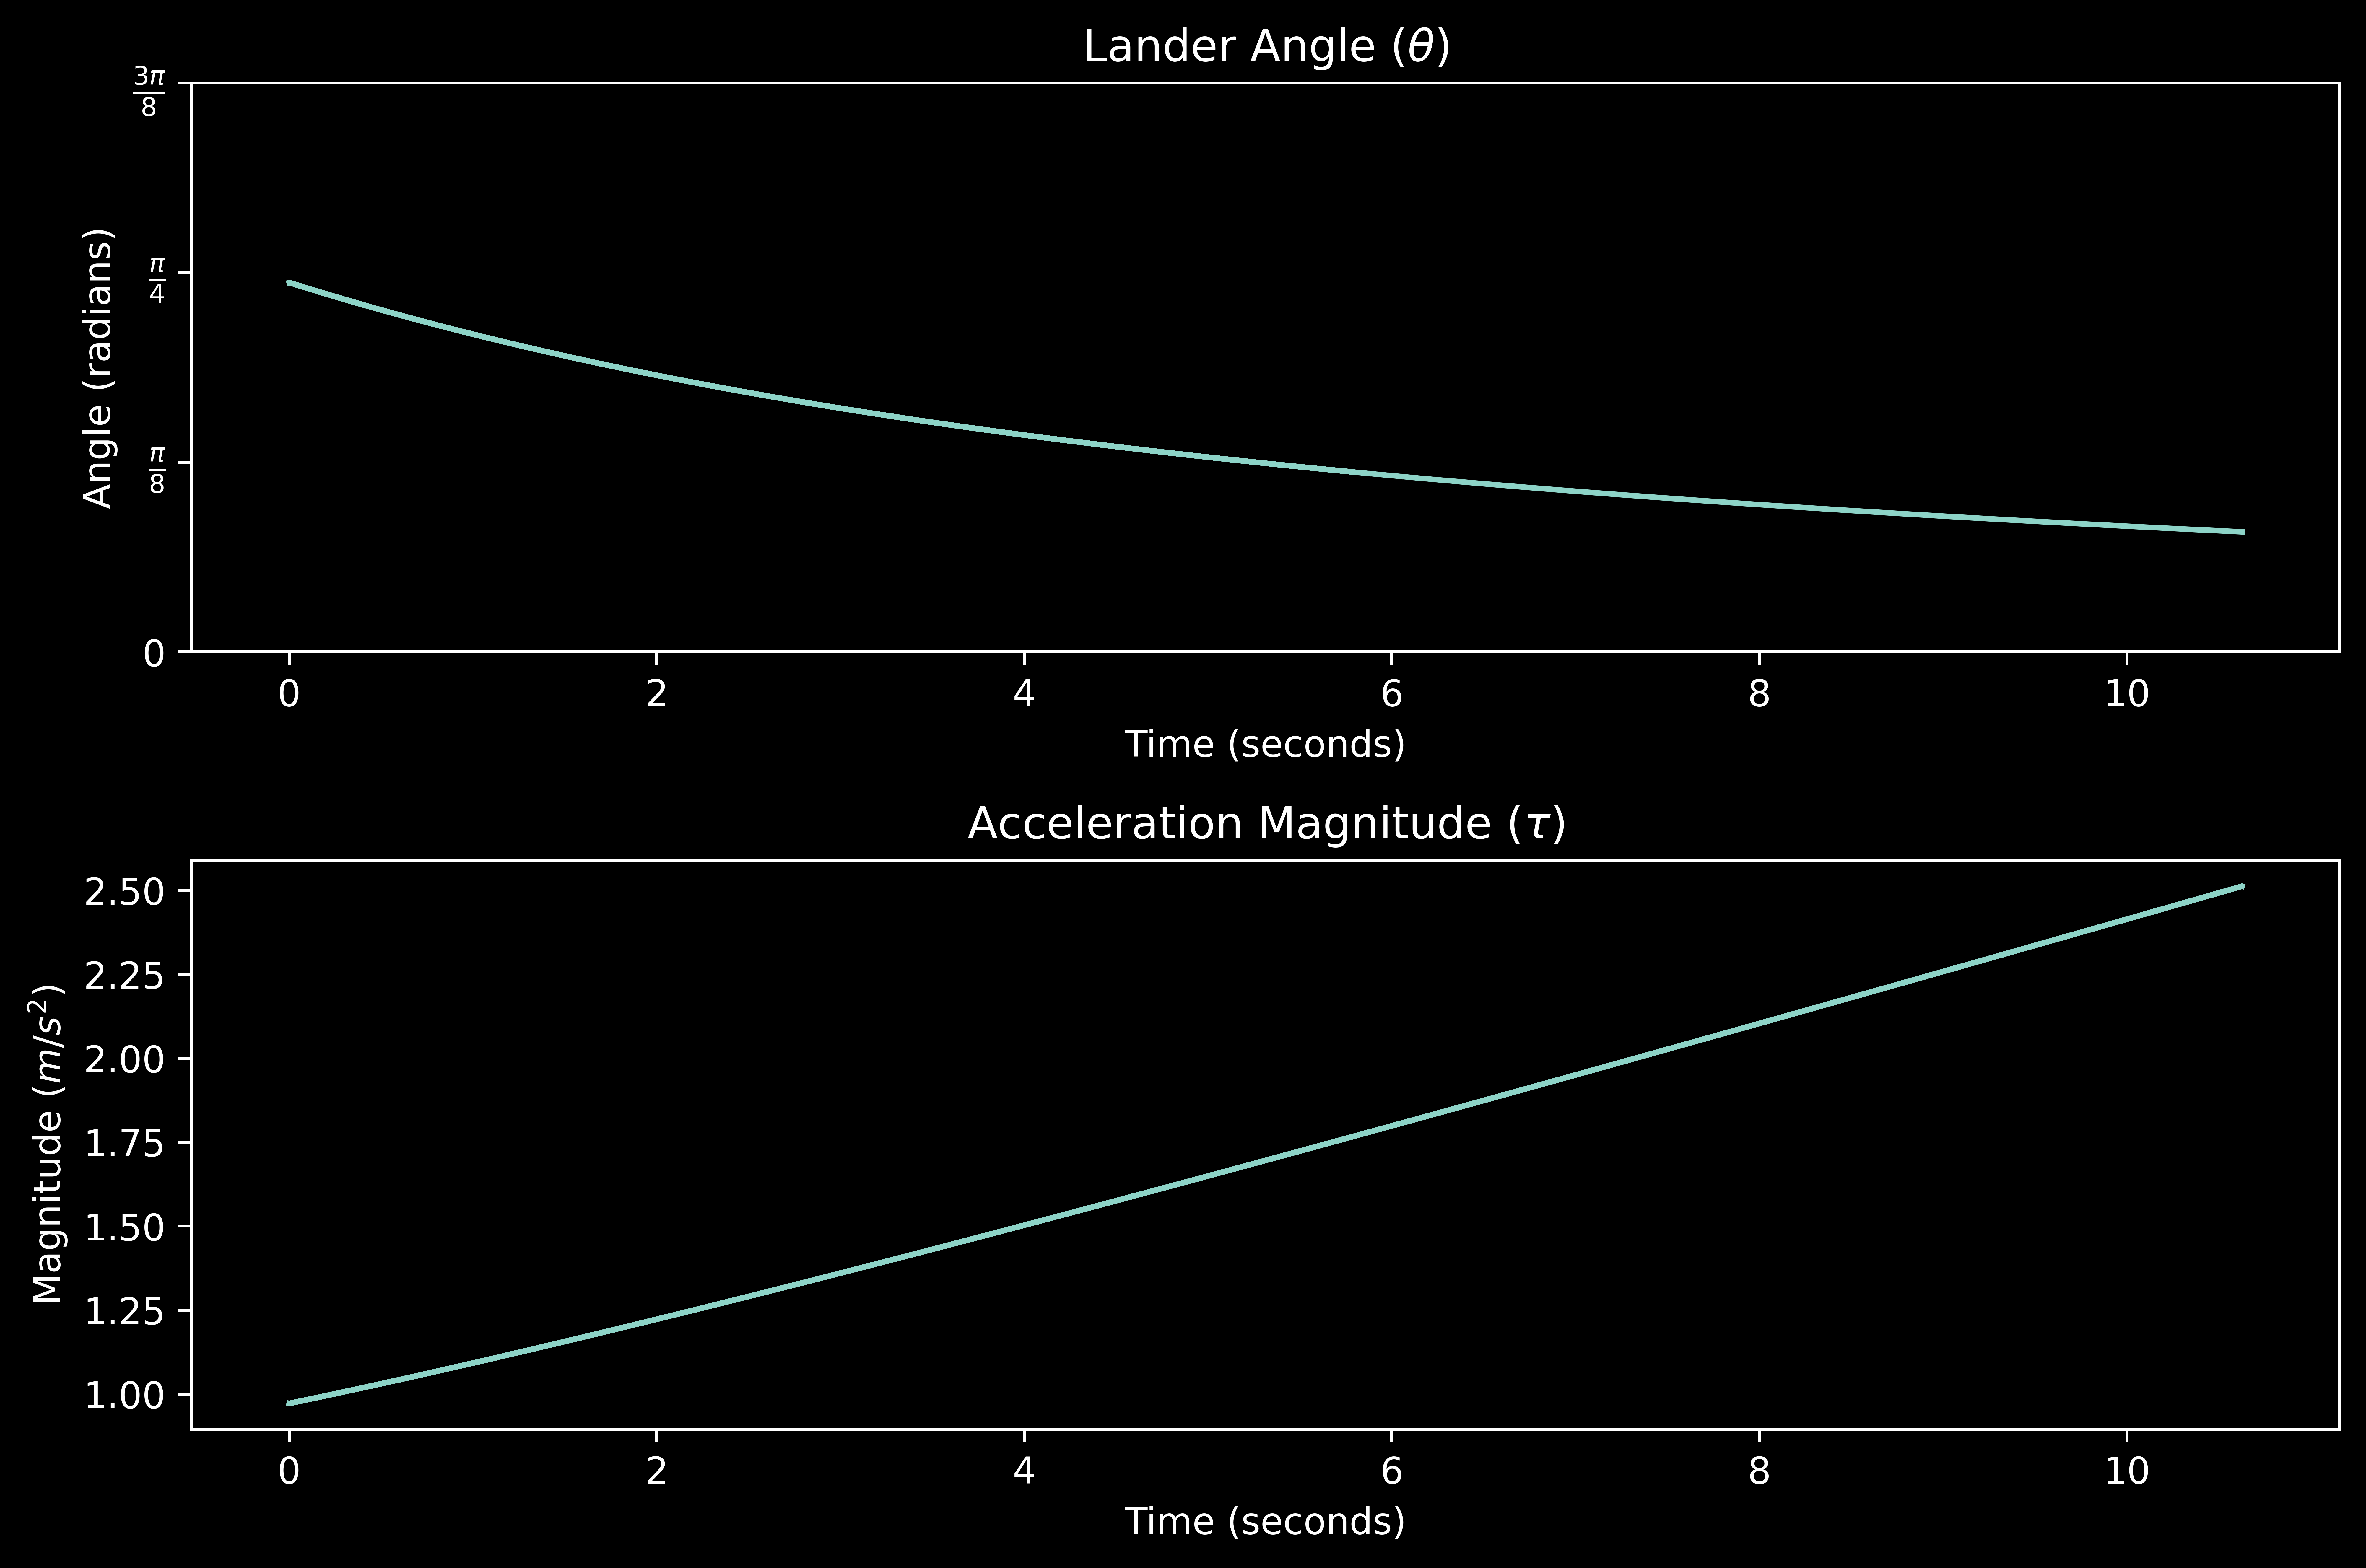

In [4]:
# make the control plot
make_control_plot(TS, UX, UY)

In [5]:
make_plots(TS, X, Y, XP, YP, UX, UY, TF)


Final Time: 10.626387266518174
Final Position: (49.876, 0.0)


### Timelapse Plot

In [6]:
np.linalg.norm(np.vstack([UX, UY]), axis=0).shape

(29998,)

In [7]:
Y.shape

(29998,)

In [8]:
np.linalg.norm(np.vstack([UX, UY]), axis=0)

array([0.97186019, 0.97181464, 0.97202703, ..., 2.51158604, 2.51187091,
       2.51180935])

In [9]:
a = np.array([0, 1, 2, 3, -4, 10])
minmax_scale(np.linalg.norm(np.vstack([UX, UY]), axis=0), (0, 1))

array([2.95762453e-05, 0.00000000e+00, 1.37911050e-04, ...,
       9.99815026e-01, 1.00000000e+00, 9.99960032e-01])

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

def plot_timelapse(ts=TS, x=X, y=Y, xp=XP, yp=YP, ux=UX, uy=UY, tf=TF, N=7, width=0.3, alpha=None, rescale_factor=3):
    # perform a rescale to make the lander look the right size
    ts = ts / rescale_factor
    x = x / rescale_factor
    y = y / rescale_factor
    xp = xp / rescale_factor
    yp = yp / rescale_factor
    ux = ux / rescale_factor
    uy = uy / rescale_factor
    tf = tf / rescale_factor
    
    def get_image(filename='./lander.png'):
        arr = plt.imread(filename)
        return arr

    def imshow_affine(ax, z, *args, **kwargs):
        im = ax.imshow(z, *args, **kwargs)
        x1, x2, y1, y2 = im.get_extent()
        im._image_skew_coordinate = (x2, y1)

        # --- Correction for aspect='auto' ---
        fig = ax.figure
        fig.canvas.draw()  # Make sure layout is updated

        # Get axis size in display units (pixels)
        bbox = ax.get_window_extent()
        width_display = bbox.width
        height_display = bbox.height

        # Get axis range in data units
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        width_data = abs(xlim[1] - xlim[0])
        height_data = abs(ylim[1] - ylim[0])

        # Calculate data-to-pixel aspect ratio
        data_ratio_x = width_display / width_data
        data_ratio_y = height_display / height_data

        # Aspect correction matrix (undistort the transform)
        correction = mtransforms.Affine2D().scale(data_ratio_y / data_ratio_x, 1)

        # Apply correction *before* any user transforms
        im.set_transform(correction + ax.transData)
        return im


    # load the image
    lander = get_image()
    lander[lander[:, :, 3] == 0] = 0
    # lander[:, :, :3][lander[:, :, 3] == 0] = 1
    # thrust = get_image('full_lander_thrust.png')[:, 3:]
    thrust = get_image('full_lander_thrust_v2.png')

    radians = np.arctan2(-ux, uy)
    thrust_mag = np.linalg.norm(np.vstack([UX, UY]), axis=0)
    # thrust_mag = minmax_scale(thrust_mag, (0, 1.5))
 
    trajectory = np.array(list(zip(x, y, radians, thrust_mag)))
    idx = np.round(np.linspace(0, len(trajectory) - 1, N)).astype(int)
    
    trajectory = np.array(trajectory)[idx]
    # max_thrust = np.max(thrust_mag)

    # set the width and height of the image
    image_ratio = lander.shape[0]/lander.shape[1]
    lander_height = width*image_ratio # this scales the image so it doesn't get distorted

    # setup the plots

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_aspect('auto')
    for i, t in enumerate(trajectory, start=1):

        #     # This allows for fading in time
        # if alpha is None:
        #     alpha=1
        # else:
        #     alpha = 0.8*i/len(trajectory)
            # alpha = .5

        xi, yi, rad, thrust_mag = t

        # stretch thrust based on thrust magnitued (acceleration mag)
        thrust_ratio = thrust_mag*(thrust.shape[0]/thrust.shape[1])
        thrust_height = width*thrust_ratio

        im_thrust = imshow_affine(ax, thrust, interpolation='none',
                                  origin='upper',
                                    extent=[0, width, -thrust_height, 0], clip_on=True,
                                    alpha=alpha)
        # center_x, center_y = width//2, thrust_height//2
        center_x, center_y = 0, 0
        im_thrust_trans = (mtransforms.Affine2D()
                    .rotate_around(center_x, center_y, rad)
                    .translate(xi, yi)
                    + ax.transData)
        im_thrust.set_transform(im_thrust_trans)

        im_lander = imshow_affine(ax, lander, interpolation='none',
                        extent=[0, width, 0, lander_height], clip_on=True,
                        alpha=alpha)
        center_x, center_y = width//2, lander_height//2 
        im_lander_trans = (mtransforms.Affine2D()
                    .rotate_around(center_x, center_y, rad)
                    .translate(xi, yi)
                    + ax.transData)
        im_lander.set_transform(im_lander_trans)
    
    # get the min and max values for the limits of the graph
    x_min = np.min(trajectory[:, 0]) - 3*width
    x_max = np.max(trajectory[:, 0]) + 3*width
    y_min = np.min(trajectory[:, 1]) - 3*lander_height
    y_max = np.max(trajectory[:, 1]) + 3*lander_height
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # now, reformat the ticks to look nice
    new_max = round(x_max, -1)
    num_ticks = int((new_max * rescale_factor) // 10 + 1)
    locs = np.linspace(0, new_max, num_ticks)
    labels = (locs * rescale_factor).astype(int).astype(str)
    ax.set_xticks(locs, labels=labels, fontsize=7)

    new_max = round(y_max, -1)
    num_ticks = int((new_max * rescale_factor) // 10 + 1)
    locs = np.linspace(0, new_max, num_ticks)
    labels = (locs * rescale_factor).astype(int).astype(str)
    ax.set_yticks(locs, labels=labels, fontsize=7)

    # finally, put in a horizontal line for the ground
    ax.hlines(0, x_min, x_max, "white", 'dashed', lw=.4)
    ax.set_title("Lander Trajectory")
    ax.set_ylabel("Y Position (meters)", fontsize=7)
    ax.set_xlabel("X Position (meters)", fontsize=7)
    # ax.set_aspect('auto')
    # plt.figure(figsize=(9, 6))
    fig.tight_layout()
    fig.savefig("thing.png")

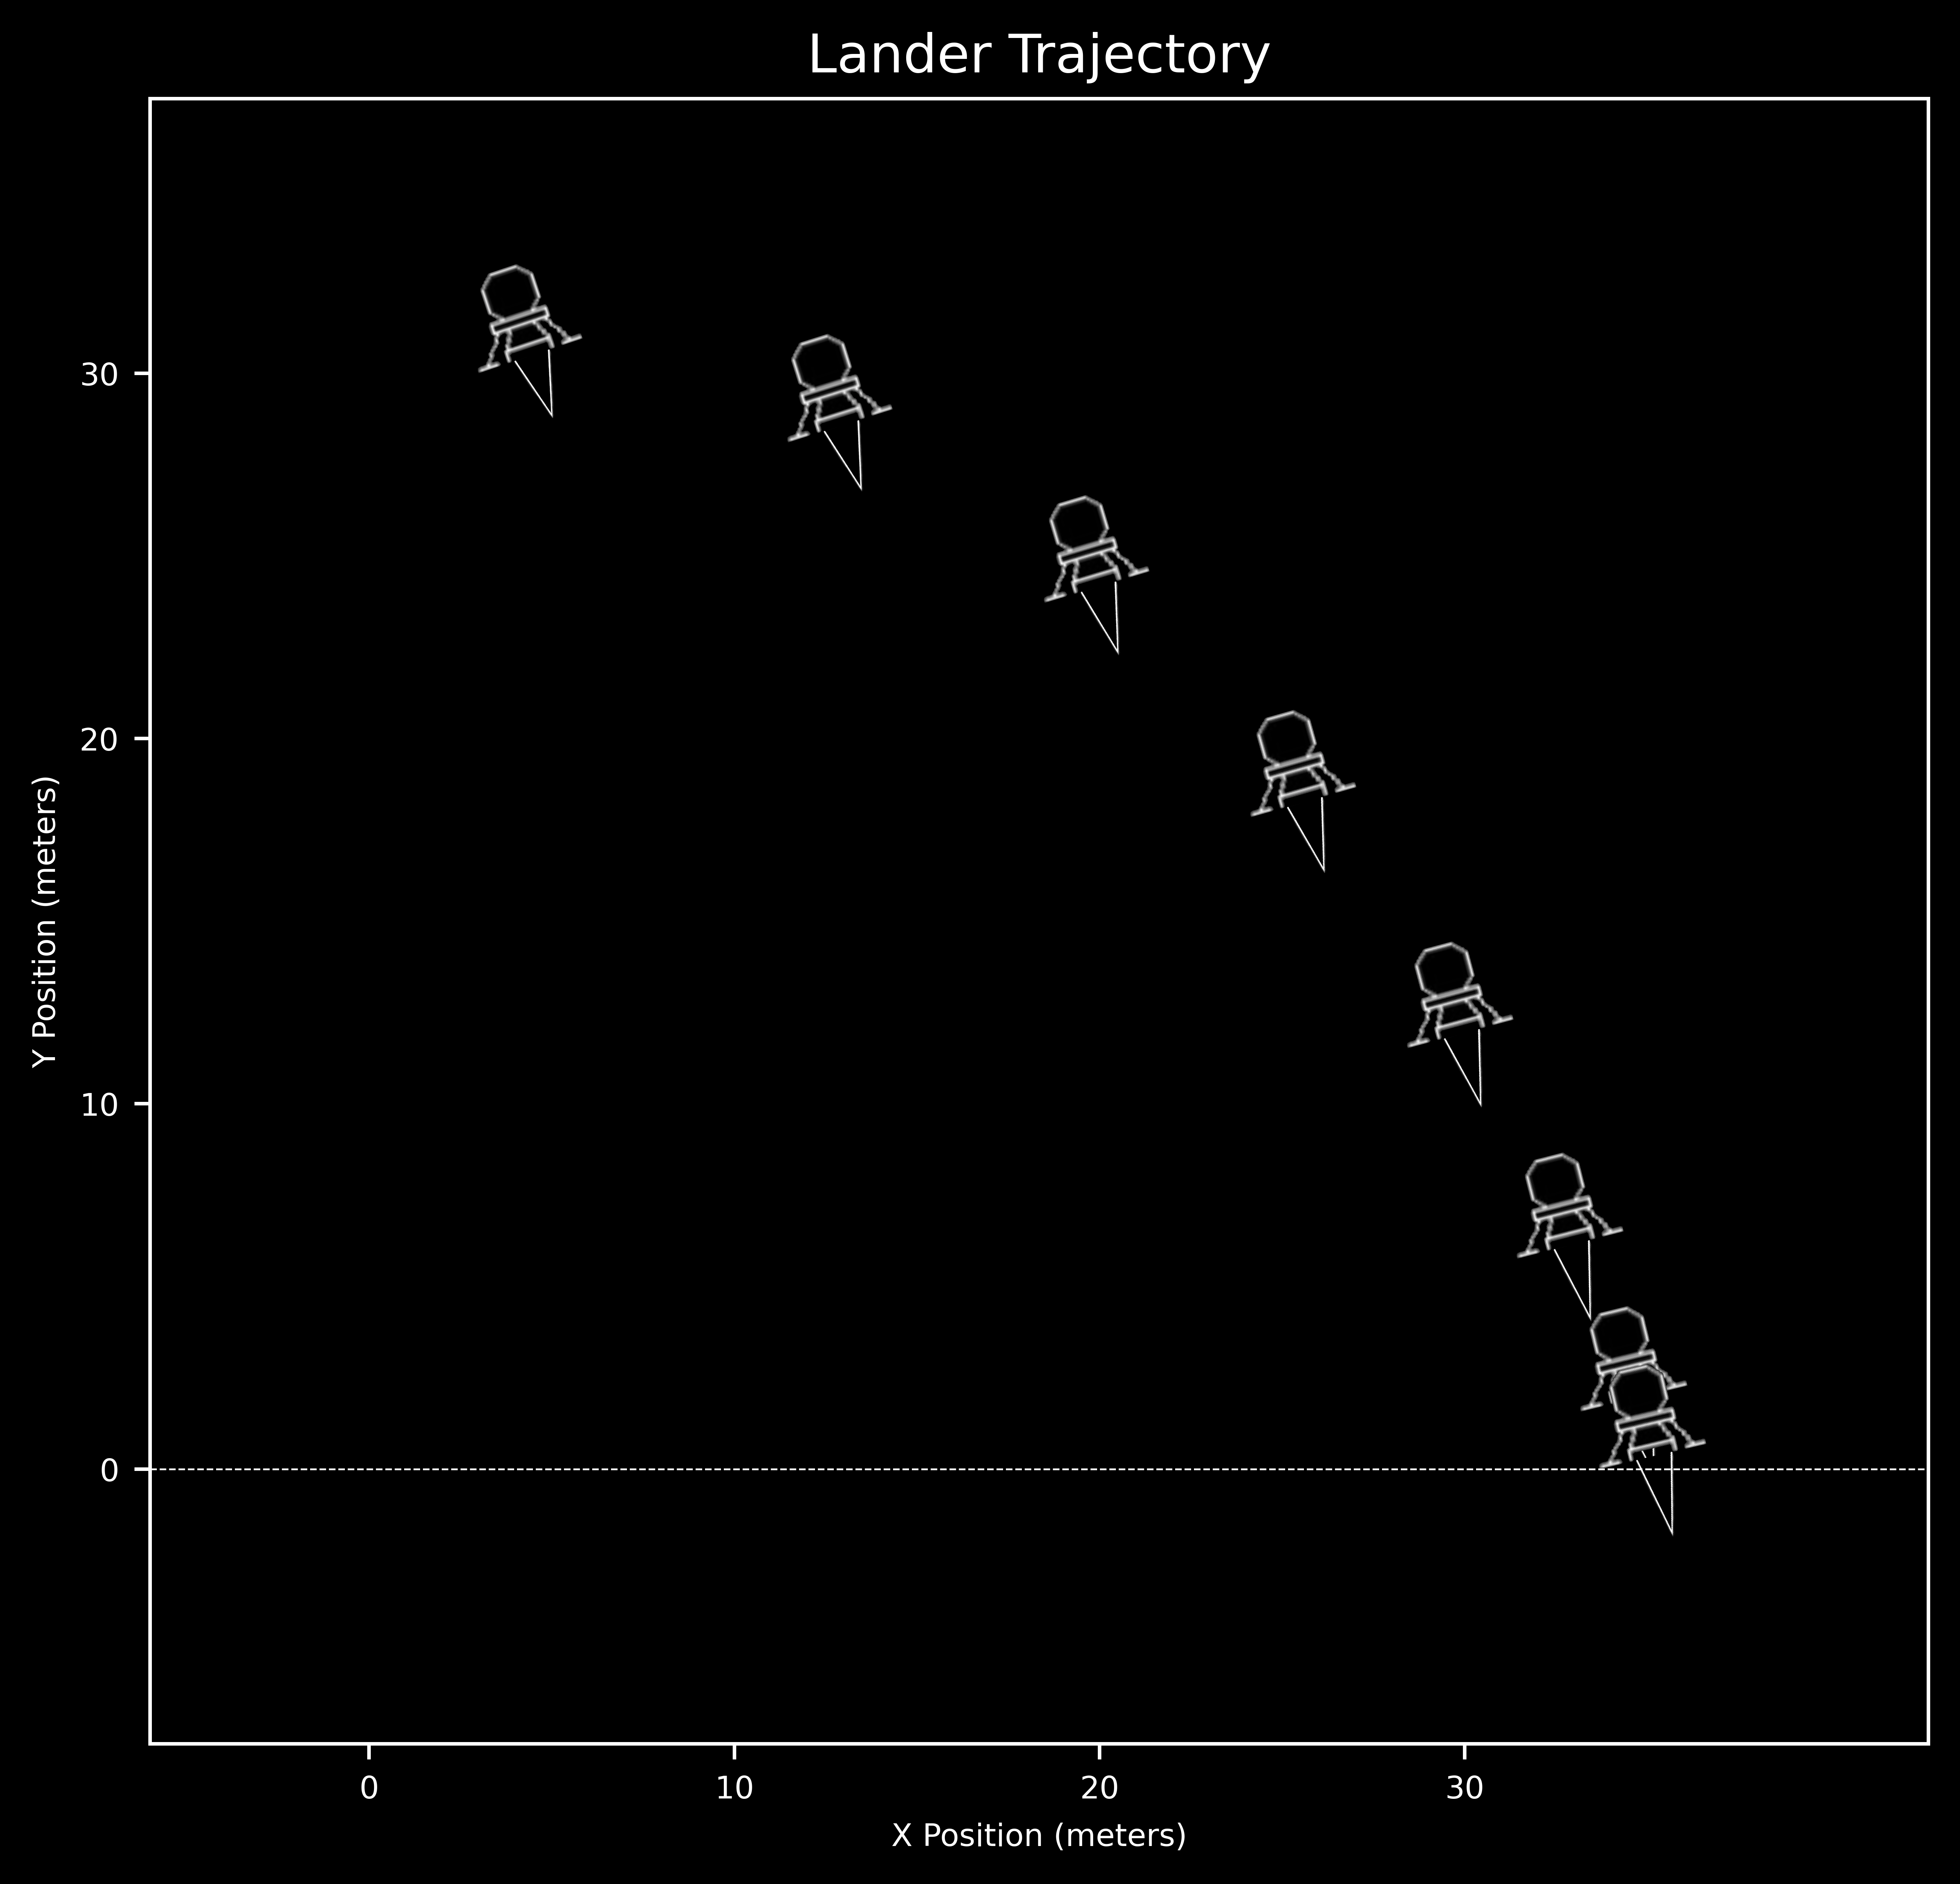

In [42]:
plot_timelapse(ts=TS, x=X, y=Y, xp=XP, yp=YP, ux=UX, uy=UY, tf=TF, N=8, width=1, alpha=None, rescale_factor=3)

In [33]:
def timelapse_test(ts=TS, x=X, y=Y, xp=XP, yp=YP, ux=UX, uy=UY, tf=TF, N=7, width=0.3, alpha=None):
    def get_image(filename='./lander.png'):
        arr = plt.imread(filename)
        return arr

    def imshow_affine(ax, z, *args, **kwargs):
        im = ax.imshow(z, *args, **kwargs)
        x1, x2, y1, y2 = im.get_extent()
        im._image_skew_coordinate = (x2, y1)
        return im

    thrust_mag = np.linalg.norm(np.vstack([UX, UY]), axis=0)
    max_thrust = np.max(thrust_mag)
    print(max_thrust)

    min_thrust = np.min(thrust_mag)
    print(min_thrust)

    trajectory = np.array([[0, 0, 0, 1],
                           [.5, 0, 30, max_thrust/5],
                           [1, 0, 60, max_thrust/5],
                           [1.5, 0, 90, max_thrust/5],
                           [1.5+.5, 0, 30, max_thrust],
                           [1.5+1, 0, 60, max_thrust],
                           [1.5+1.5, 0, 90, max_thrust],
                           [.5, 1, 30, max_thrust/5],
                           [1, 1, 60, max_thrust/5],
                           [1.5, 1, 90, max_thrust/5],
                           [1.5+.5, 1, 30, max_thrust],
                           [1.5+1, 1, 60, max_thrust],
                           [1.5+1.5, 1, 90, max_thrust],
                           [.5, -1, 30, max_thrust/5],
                           [1, -1, 60, max_thrust/5],
                           [1.5, -1, 90, max_thrust/5],
                           [1.5+.5, -1, 30, max_thrust],
                           [1.5+1, -1, 60, max_thrust],
                           [1.5+1.5, -1, 90, max_thrust],])
    trajectory[:, 0] = trajectory[:, 0]**2
    

    # load the image
    lander = get_image()
    thrust = get_image('full_lander_thrust.png')
    # thrust += .4 

    print(f'lander.shape, {lander.shape}')
    print(f'thrust.shape, {thrust.shape}')

    # set the width and height of the image
    lander_ratio = lander.shape[0]/lander.shape[1]
    lander_height = width*lander_ratio # this scales the image so it doesn't get distorted

    # This allows for fading in time
    if alpha is None:
        alpha=1
    else:
        alpha = 0.8*i/len(trajectory)

    # setup the plots
    fig, ax = plt.subplots()
    for i, t in enumerate(trajectory, start=1):
        xi, yi, deg, thrust_mag = t
        # print(xi, yi, deg, thrust)
        thrust_ratio = thrust_mag*(thrust.shape[0]/thrust.shape[1])
        thrust_height = width*thrust_ratio

        im_thrust = imshow_affine(ax, thrust, interpolation='none',
                                  origin='upper',
                                    extent=[0, width, -thrust_height, 0], clip_on=True,
                                    alpha=alpha)
        # center_x, center_y = width//2, thrust_height//2
        center_x, center_y = 0, 0
        # print(center_x, center_y, xi, yi)
        im_thrust_trans = (mtransforms.Affine2D()
                    .rotate_deg_around(center_x, center_y, deg)
                    .translate(xi, yi)
                    + ax.transData)
        im_thrust.set_transform(im_thrust_trans)

        # print("thrust info")
        # print(f'center_x:  {center_x}, center_y:  {center_y}, xi: {xi}, yi: {yi}')
        # print(f'width: {width}, height: {thrust_height}')


        im_lander = imshow_affine(ax, lander, interpolation='none',
                        extent=[0, width, 0, lander_height], clip_on=True,
                        alpha=alpha)
        center_x, center_y = width//2, lander_height//2
        # print("lander info")
        # print(f'center_x:  {center_x}, center_y:  {center_y}, xi: {xi}, yi: {yi}')
        # print(f'width: {width}, height: {lander_height}')

        im_lander_trans = (mtransforms.Affine2D()
                    .rotate_deg_around(center_x, center_y, deg)
                    .translate(xi, yi)
                    + ax.transData)
        im_lander.set_transform(im_lander_trans)

    ax.set_xlim(0, 3.5)
    ax.set_ylim(-1.5, 1.5)
    plt.show()

1.4196919716791387
1.1235540371556205
lander.shape, (213, 255, 4)
thrust.shape, (181, 255, 4)


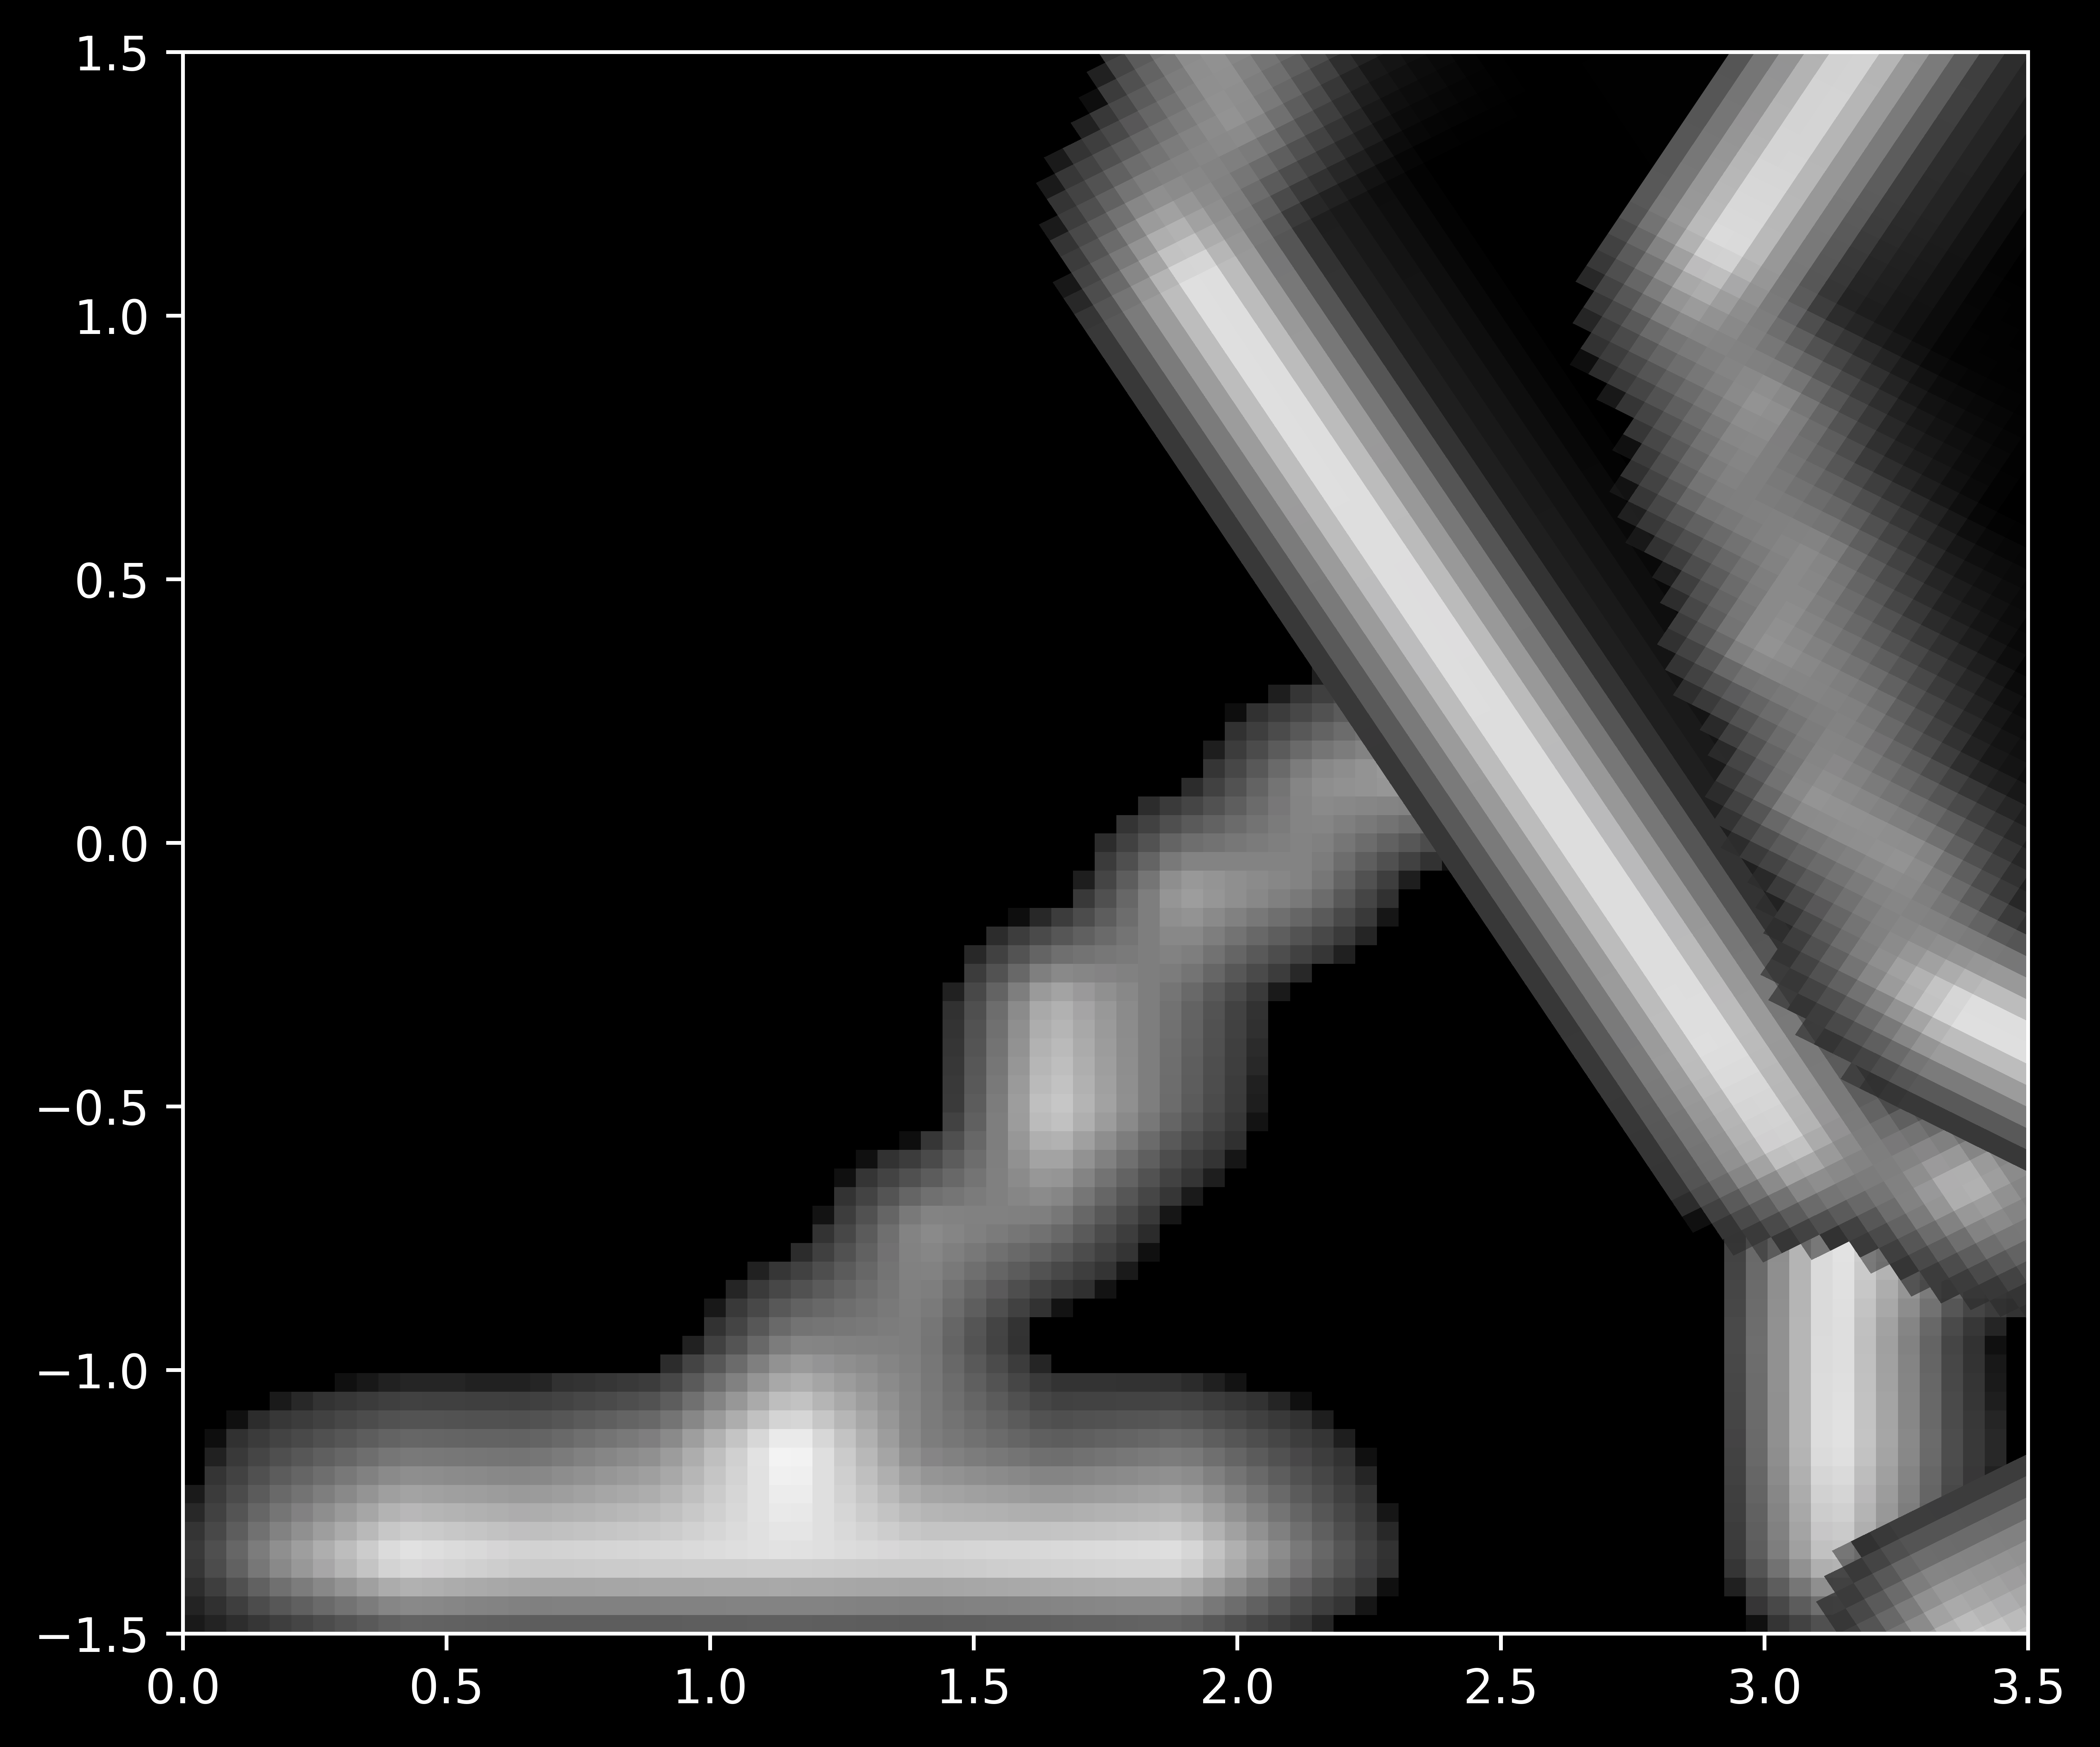

In [34]:
timelapse_test(width=3)

In [14]:
# G_moon = 200 # m/s
altitude = 50. # m
x_pos = 5. # m? (don't think this really matters)
entrance_x_vel = 10. # m/s
pos = (x_pos, altitude)
gamma=0
nu = 5000
beta=100

new_altitude = 30. # m
new_x_pos = (new_altitude/altitude)*(5.) # m? (don't think this really matters)
new_entrance_x_vel = (new_altitude/altitude)*10. # m/s
new_pos = (new_x_pos, new_altitude)
new_gamma=(new_altitude/altitude)*0
new_nu = (new_altitude/altitude)*5000.
new_beta = (new_altitude/altitude)*100.
new_tf_guess = (new_altitude/altitude)*20.
new_y0_guess = (new_altitude/altitude)*1.
new_G = (new_altitude/altitude)*2.
new_alpha = (new_altitude/altitude)*10


TS, X, Y, XP, YP, UX, UY, TF = lunar_lander(pos_init=new_pos, 
                                            v_init=new_entrance_x_vel, 
                                            tf_guess=new_tf_guess, 
                                            y0_guess=new_y0_guess, 
                                            alpha=new_alpha, 
                                            beta=new_beta, 
                                            gamma=new_gamma, 
                                            nu=new_nu, 
                                            G=new_G,
                                            t_steps=10000)

In [15]:
make_plots(TS, X, Y, XP, YP, UX, UY, TF)

Final Time: 11.423001593281967
Final Position: (33.691, -0.0)


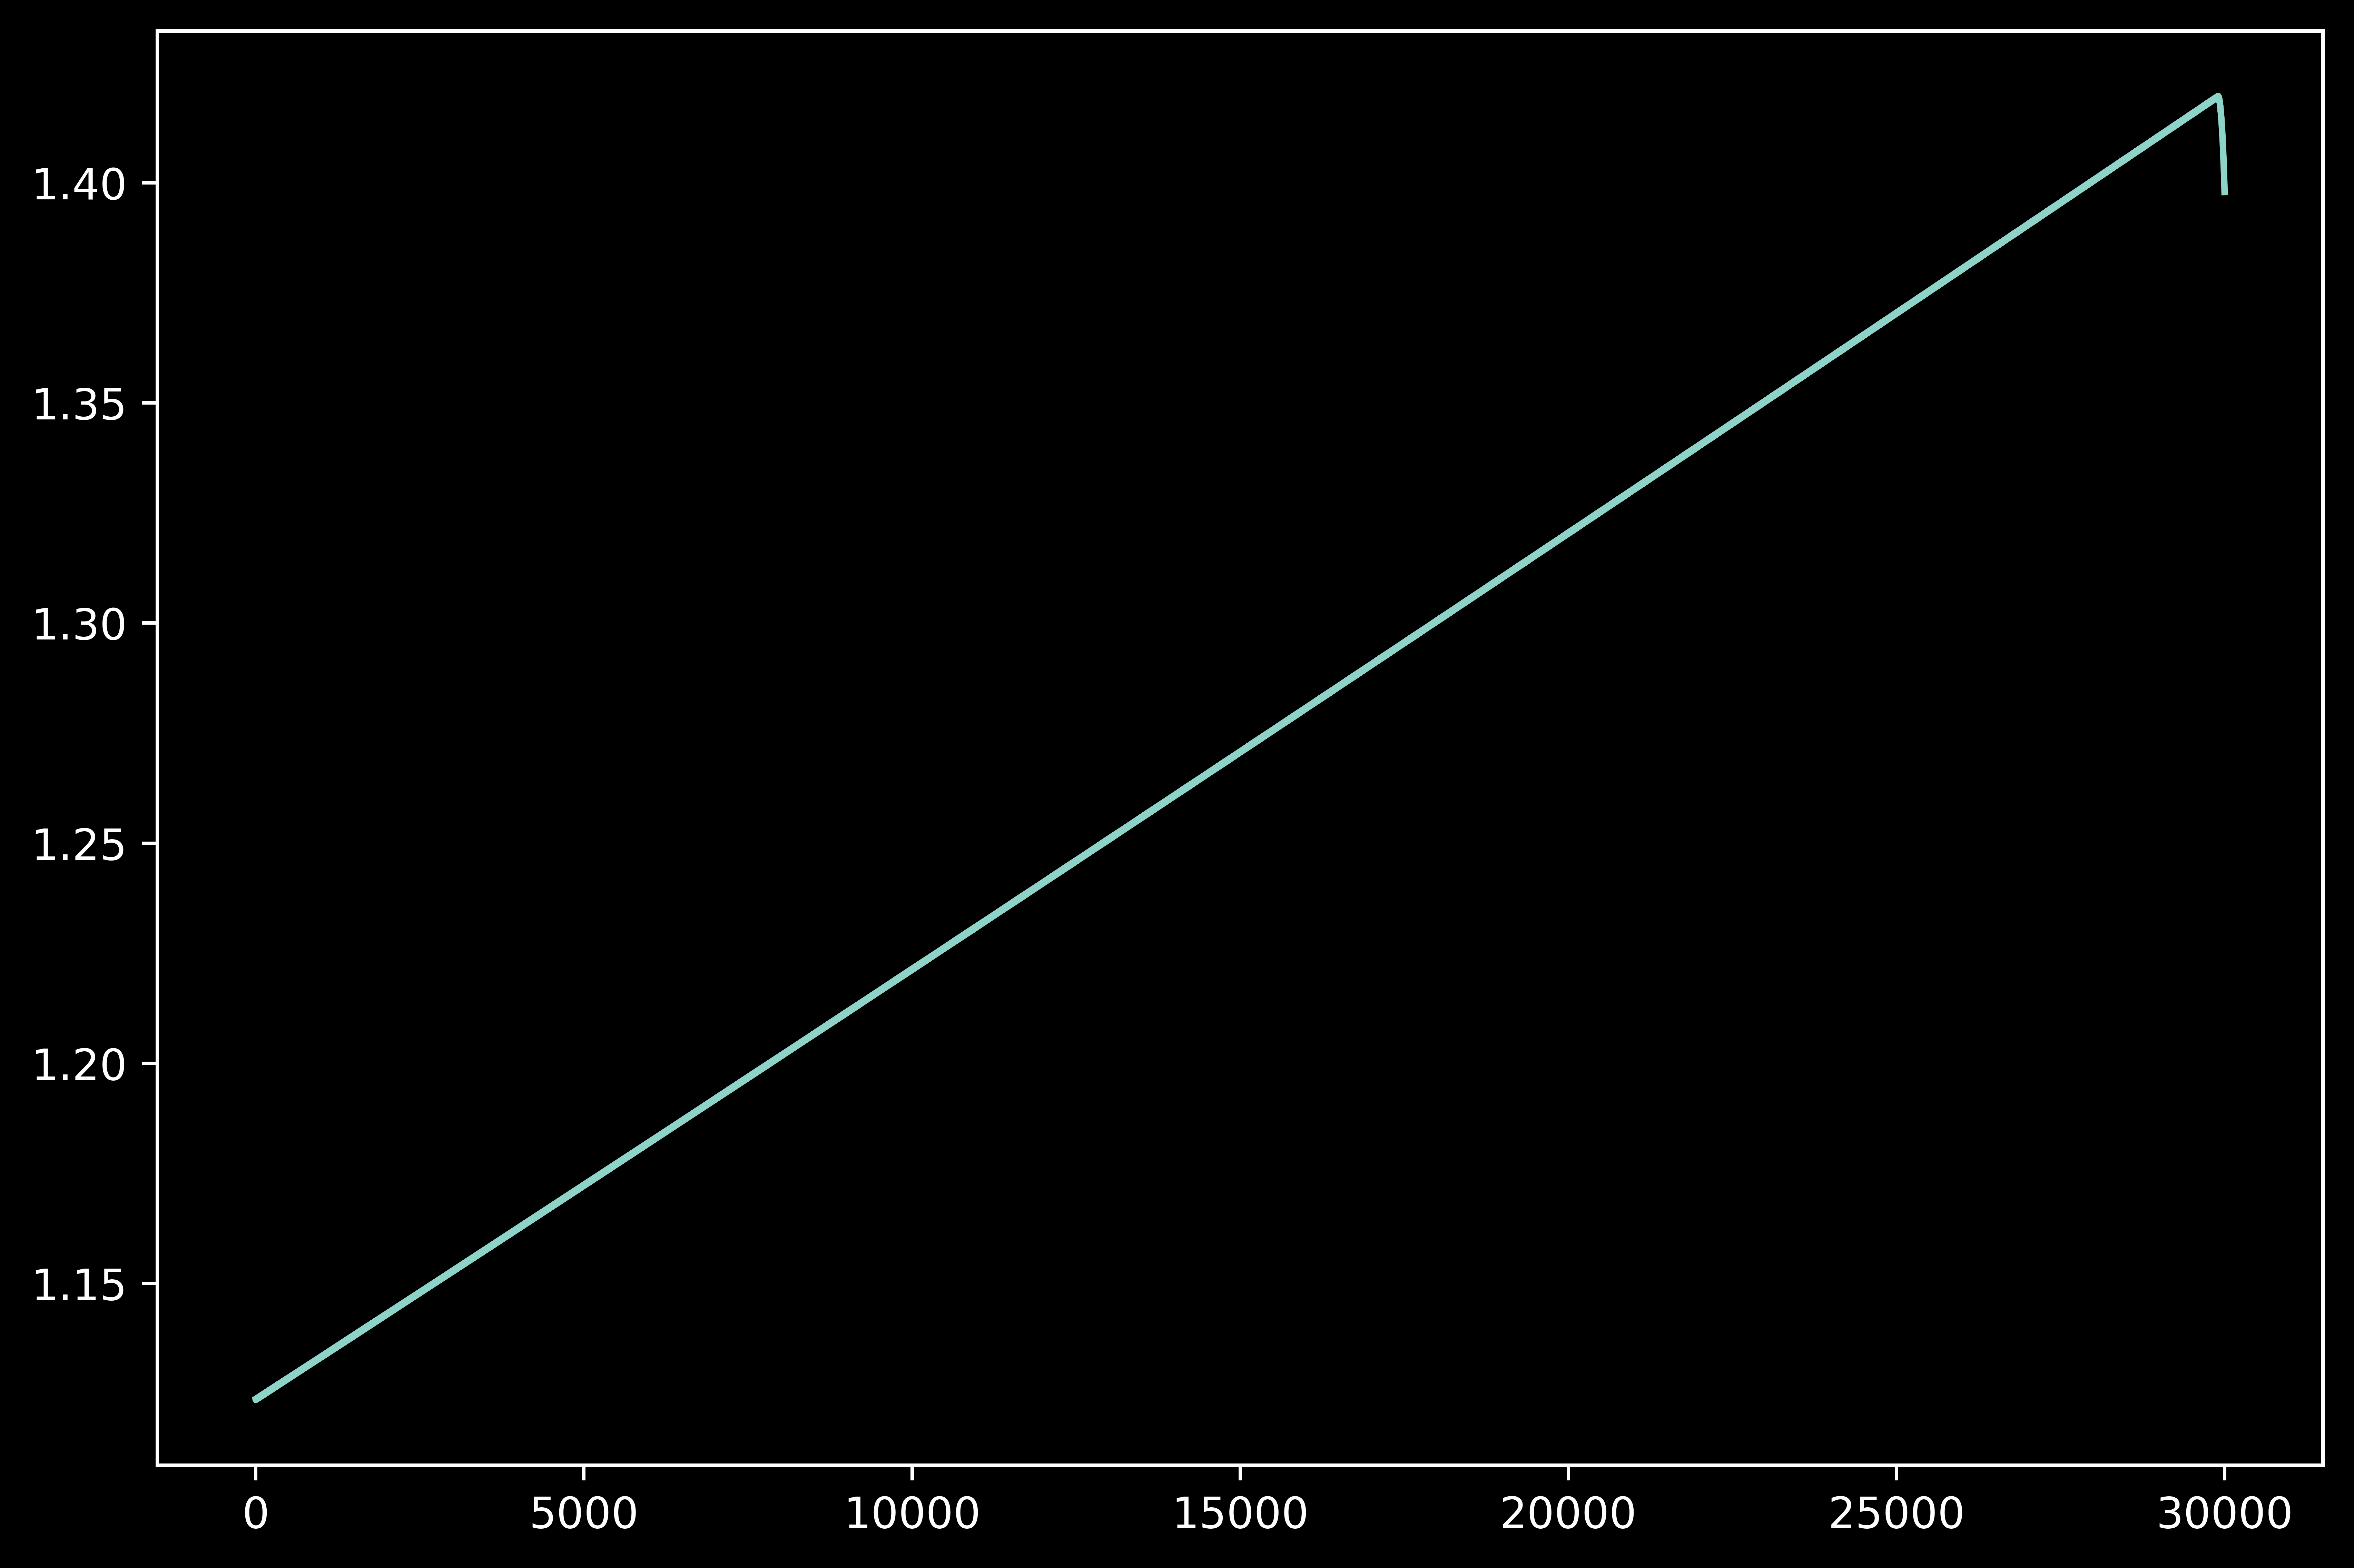

In [16]:
accel_mag = np.linalg.norm(np.vstack([UX, UY]), axis=0)
plt.plot(accel_mag)

In [19]:
def timelapse_test(ts=TS, x=X, y=Y, xp=XP, yp=YP, ux=UX, uy=UY, tf=TF, N=7, width=0.3, alpha=None):
    def get_image(filename='./lander.png'):
        arr = plt.imread(filename)
        return arr

    def imshow_affine(ax, z, *args, **kwargs):
        im = ax.imshow(z, *args, **kwargs)
        x1, x2, y1, y2 = im.get_extent()
        im._image_skew_coordinate = (x2, y1)
        return im

    # load the image
    lander = get_image()
    # thrust = get_image('full_lander_thrust.png')[:, 3:]
    thrust = get_image('full_lander_thrust.png')

    radians = np.arctan2(-ux, uy)
    thrust_mag = np.linalg.norm(np.vstack([UX, UY]), axis=0)
    thrust_mag = minmax_scale(thrust_mag, (0, 1))
    print(thrust_mag.shape)
    trajectory = np.array(list(zip(x, y, radians, thrust_mag)))
    idx = np.round(np.linspace(0, len(trajectory) - 1, N)).astype(int)
    
    trajectory = np.array(trajectory)[idx]
    # max_thrust = np.max(thrust_mag)

    # set the width and height of the image
    image_ratio = lander.shape[0]/lander.shape[1]
    lander_height = width*image_ratio
    # This allows for fading in time
    if alpha is None:
        alpha=1
    else:
        alpha = 0.8*i/len(trajectory)

    # setup the plots
    fig, ax = plt.subplots(figsize=(9, 6))
    for i, t in enumerate(trajectory, start=1):
        xi, yi, deg, thrust_mag = t
        # print(xi, yi, deg, thrust)
        thrust_ratio = thrust_mag**2.5 * (thrust.shape[0]/thrust.shape[1])
        thrust_height = width*thrust_ratio

        im_thrust = imshow_affine(ax, thrust, interpolation='none',
                                  origin='upper',
                                    extent=[0, width, -thrust_height, 0], clip_on=True,
                                    alpha=alpha)
        # center_x, center_y = width//2, thrust_height//2
        center_x, center_y = 0, 0
        # print(center_x, center_y, xi, yi)
        im_thrust_trans = (mtransforms.Affine2D()
                    .rotate_around(center_x, center_y, deg)
                    .translate(xi, yi)
                    + ax.transData)
        im_thrust.set_transform(im_thrust_trans)

        # print("thrust info")
        # print(f'center_x:  {center_x}, center_y:  {center_y}, xi: {xi}, yi: {yi}')
        # print(f'width: {width}, height: {thrust_height}')


        im_lander = imshow_affine(ax, lander, interpolation='none',
                        extent=[0, width, 0, lander_height], clip_on=True,
                        alpha=alpha)
        center_x, center_y = width//2, lander_height//2
        # print("lander info")
        # print(f'center_x:  {center_x}, center_y:  {center_y}, xi: {xi}, yi: {yi}')
        # print(f'width: {width}, height: {lander_height}')

        im_lander_trans = (mtransforms.Affine2D()
                    .rotate_around(center_x, center_y, deg)
                    .translate(xi, yi)
                    + ax.transData)
        im_lander.set_transform(im_lander_trans)

    ax.set_xlim(np.min(trajectory[:, 0]) - 3*width, np.max(trajectory[:, 0]) + 3*width)
    ax.set_ylim(np.min(trajectory[:, 1]) - 3*lander_height, np.max(trajectory[:, 1]) + 3*lander_height)
    plt.show()

(29998,)


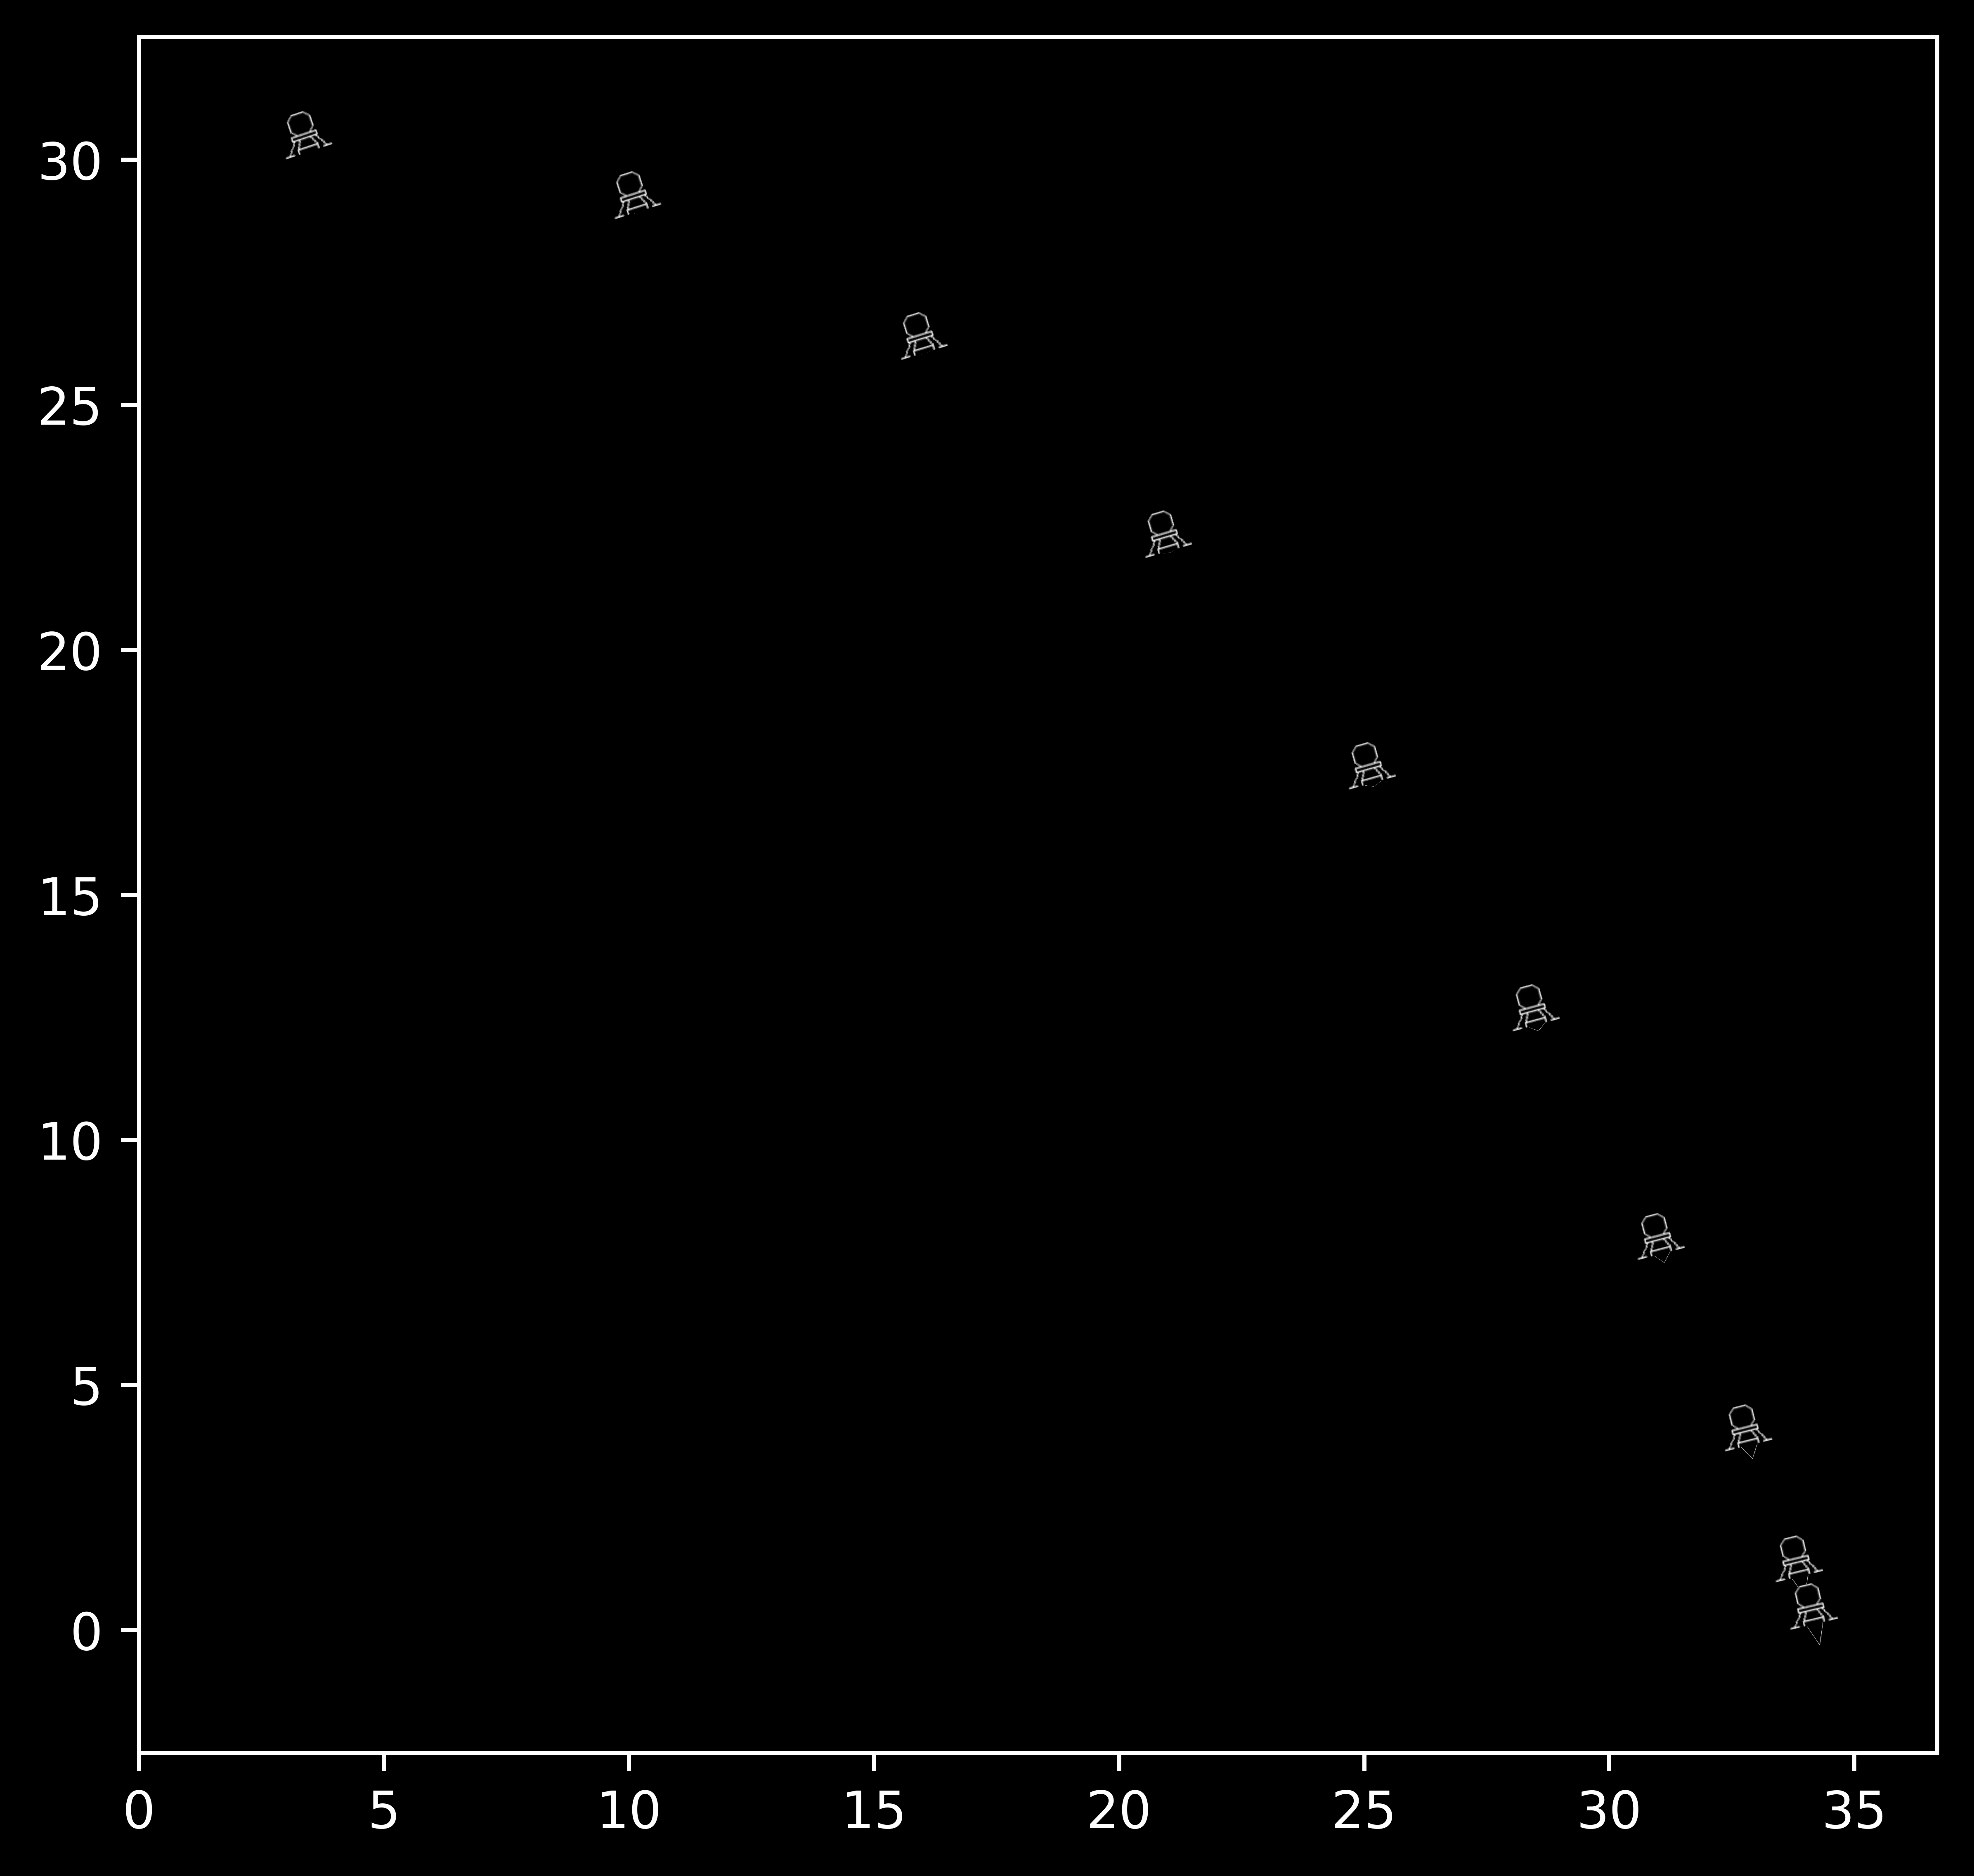

In [22]:
timelapse_test(width=1, N=10)